<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Load-the-libraries" data-toc-modified-id="Load-the-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the libraries</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Text-Data-Processing" data-toc-modified-id="Text-Data-Processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Text Data Processing</a></span></li><li><span><a href="#Text-Features-Generation" data-toc-modified-id="Text-Features-Generation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Text Features Generation</a></span></li><li><span><a href="#Correlation-of-newly-created-features" data-toc-modified-id="Correlation-of-newly-created-features-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Correlation of newly created features</a></span></li></ul></div>

# Description
Twitter sentiment analysis.

# Load the libraries

In [4]:
import sys
sys.path.append('/Users/poudel/opt/miniconda3/envs/nlp/lib/python3.7/site-packages')

In [44]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import mlxtend
import plotly_express as px

pd.options.plotting.backend = "matplotlib"
pd.set_option('max_colwidth',500)

import time,os,json,sys
time_start_notebook = time.time()
home = os.path.expanduser('~')
SEED=100

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print([(x.__name__,x.__version__) for x in [np,pd,sns,sklearn,mlxtend,px]])


#========= NLP
import re
import string
import nltk
import spacy
import textblob
import gensim
import texthero

from nltk.corpus import stopwords

print([(x.__name__,x.__version__) for x in [nltk,spacy,textblob,gensim]])

#=======OTHERS
import scipy
import multiprocessing as mp

[('numpy', '1.17.5'), ('pandas', '1.0.5'), ('seaborn', '0.10.1'), ('sklearn', '0.23.1'), ('mlxtend', '0.17.0'), ('plotly_express', '0.4.1')]
[('nltk', '3.4.4'), ('spacy', '2.2.3'), ('textblob', '0.15.3'), ('gensim', '3.8.3')]


# Load the data

In [57]:
df_train_raw = pd.read_csv('../data/raw/train.csv')
df_test_raw = pd.read_csv('../data/raw/test.csv')

df = df_train_raw.append(df_test_raw)
df = df.reset_index()

print(f"shape df_train_raw: {df_train_raw.shape}")
print(f"shape df_test_raw: {df_test_raw.shape}")

df.head(2).append(df.tail(2))

target = 'label'
maincol = 'tweet'
mc = maincol + '_clean'
mcl = maincol + '_lst_clean'

shape df_train_raw: (7920, 3)
shape df_test_raw: (1953, 2)


# Useful Functions

In [47]:
import multiprocessing as mp
def parallelize_dataframe(df, func):
    ncores = mp.cpu_count()
    df_split = np.array_split(df, ncores)
    pool = mp.Pool(ncores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

# Text Data Processing

In [31]:
def process_text(text):
    """
    Do a basic text processing.

    Parameters
    -----------
    text : string
        
    Returns
    --------
    This function returns pandas series having one list
    with clean text.
    1: split combined text
    2: lowercase
    3: expand apostrophes
    4: remove punctuation
    5: remove digits
    6: remove repeated substring
    7: remove stop words
    8: lemmatize

    Example:
    ========
    import re
    import string
    from nltk.corpus import stopwords
    import nltk
    
    text = "I'm typing text2num! areYou ? If yesyes say yes pals!"
    process_text(text)
    # ['typing', 'textnum', 'yes', 'say', 'yes', 'pal']

    """
    ser = pd.Series([text])
    
    # step1: Split combined words areYou ==> are You
    #s1 = ser.apply(lambda x: re.sub(r'([a-z])([A-Z])',r'\1 \2',x))
    s1 = ser

    # step2: lowercase
    s2 = s1.str.lower()

    # step3: expand apostrophes
    map_apos = {
        "you're": 'you are',
        "i'm": 'i am',
        "he's": 'he is',
        "she's": 'she is',
        "it's": 'it is',
        "they're": 'they are',
        "can't": 'can not',
        "couldn't": 'could not',
        "don't": 'do not',
        "don;t": 'do not',
        "didn't": 'did not',
        "doesn't": 'does not',
        "isn't": 'is not',
        "wasn't": 'was not',
        "aren't": 'are not',
        "weren't": 'were not',
        "won't": 'will not',
        "wouldn't": 'would not',
        "hasn't": 'has not',
        "haven't": 'have not',
        "what's": 'what is',
        "that's": 'that is',
    }

    s3a = pd.Series(s2.str.split()[0])
    s3b = s3a.map(map_apos).fillna(s3a)
    sentence = s3b.str.cat(sep=' ')
    s3 = pd.Series([sentence])

    # step4: remove punctuation
    s4 = s3.str.translate(str.maketrans(' ',' ',
                                        string.punctuation))
    # step5: remove digits
    s5 = s4.str.translate(str.maketrans(' ', ' ', '\n'))
    s5 = s5.str.translate(str.maketrans(' ', ' ', string.digits))

    # step6: remove repeated substring yesyes ==> yes
    s6 = s5.str.replace(r'(\w+)\1',r'\1',regex=True)

    # step7: remove stop words
    stop = set(stopwords.words('English'))
    extra_stop_words = ['...']
    stop.update(extra_stop_words) # inplace operation
    s7 = s6.str.split()
    s7 = s7.apply(lambda x: [I for I in x if I not in stop])

    # step8: convert word to base form or lemmatize
    lemmatizer = nltk.stem.WordNetLemmatizer()
    s8 = s7.apply(lambda lst: [lemmatizer.lemmatize(word) 
                               for word in lst])

    return s8.to_numpy()[0]

text = "I'm typing text2num! areYou ? If yesyes say yes pals!"
# ['typing', 'textnum', 'yes', 'say', 'yes', 'pal']
process_text(text)

['typing', 'textnum', 'areyou', 'yes', 'say', 'yes', 'pal']

In [39]:
def add_features(df):
    df[mcl] = df[maincol].apply(process_text)
    df[mc] = df[mcl].str.join(' ')
    return df

In [40]:
%%time
df = parallelize_dataframe(df, add_features)

CPU times: user 87.6 ms, sys: 54.4 ms, total: 142 ms
Wall time: 13.3 s


In [45]:
df.head()

,index,id,label,tweet,tweet_lst_clean,tweet_clean
0,0,1,0.0,#fingerprint #Pregnancy Test https://goo.gl/h1MfQV #android #apps #beautiful #cute #health #igers #iphoneonly #iphonesia #iphone,"[fingerprint, pregnancy, test, htpsgoglhmfqv, android, aps, beautiful, cute, health, igers, iphoneonly, iphonesia, iphone]",fingerprint pregnancy test htpsgoglhmfqv android aps beautiful cute health igers iphoneonly iphonesia iphone
1,1,2,0.0,Finally a transparant silicon case ^^ Thanks to my uncle :) #yay #Sony #Xperia #S #sonyexperias… http://instagram.com/p/YGEt5JC6JM/,"[finaly, transparant, silicon, case, thanks, uncle, yay, sony, xperia, sonyexperias…, htpinstagramcompygetjcjm]",finaly transparant silicon case thanks uncle yay sony xperia sonyexperias… htpinstagramcompygetjcjm
2,2,3,0.0,We love this! Would you go? #talk #makememories #unplug #relax #iphone #smartphone #wifi #connect... http://fb.me/6N3LsUpCu,"[love, would, go, talk, makemories, unplug, relax, iphone, smartphone, wifi, conect, htpfbmenlsupcu]",love would go talk makemories unplug relax iphone smartphone wifi conect htpfbmenlsupcu
3,3,4,0.0,I'm wired I know I'm George I was made that way ;) #iphone #cute #daventry #home http://instagr.am/p/Li_5_ujS4k/,"[wired, know, george, made, way, iphone, cute, daventry, home, htpinstagrampliujsk]",wired know george made way iphone cute daventry home htpinstagrampliujsk
4,4,5,1.0,What amazing service! Apple won't even talk to me about a question I have unless I pay them $19.95 for their stupid support!,"[amazing, service, aple, wil, even, talk, question, unles, pay, stupid, suport]",amazing service aple wil even talk question unles pay stupid suport


In [46]:
# note: I see some ... I need to remove them.

# Text Features Generation

In [52]:
def create_text_features(df):
    # total
    df['total_length'] = df[maincol].apply(len)

    # num of word and sentence
    df['num_words'] = df[maincol].apply(lambda x: len(x.split()))

    df['num_sent']=df[maincol].apply(lambda x: 
                                len(re.findall("\n",str(x)))+1)

    df['num_unique_words'] = df[maincol].apply(
        lambda x: len(set(w for w in x.split())))

    df["num_words_title"] = df[maincol].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

    df['num_uppercase'] = df[maincol].apply(
        lambda x: sum(1 for c in x if c.isupper()))

    # num of certain characters ! ? . @
    df['num_exclamation_marks'] = df[maincol].apply(lambda x: x.count('!'))

    df['num_question_marks'] = df[maincol].apply(lambda x: x.count('?'))

    df['num_punctuation'] = df[maincol].apply(
        lambda x: sum(x.count(w) for w in '.,;:'))

    df['num_symbols'] = df[maincol].apply(
        lambda x: sum(x.count(w) for w in '*&$%'))

    # average
    df["avg_word_len"] = df[maincol].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    df['avg_uppercase'] = df.apply(
        lambda row: float(row['num_uppercase'])/float(row['total_length']),
                                    axis=1)
    
    df['avg_unique'] = df['num_unique_words'] / df['num_words']
    
    return df

In [53]:
%%time
df = parallelize_dataframe(df, create_text_features)

CPU times: user 73.5 ms, sys: 53.9 ms, total: 127 ms
Wall time: 470 ms


# Correlation of newly created features

In [54]:
df.columns

Index(['index', 'id', 'label', 'tweet', 'tweet_lst_clean', 'tweet_clean',
       'total_length', 'num_words', 'num_sent', 'num_unique_words',
       'num_words_title', 'num_uppercase', 'num_exclamation_marks',
       'num_question_marks', 'num_punctuation', 'num_symbols', 'avg_word_len',
       'avg_uppercase', 'avg_unique'],
      dtype='object')

In [55]:
features =  ['total_length', 'num_words', 'num_sent',
             'num_unique_words','num_words_title',
             'num_uppercase', 'num_exclamation_marks',
             'num_question_marks', 'num_punctuation',
             'num_symbols', 'avg_word_len',
             'avg_uppercase', 'avg_unique']

df_corr = df[['label'] + features].corr()

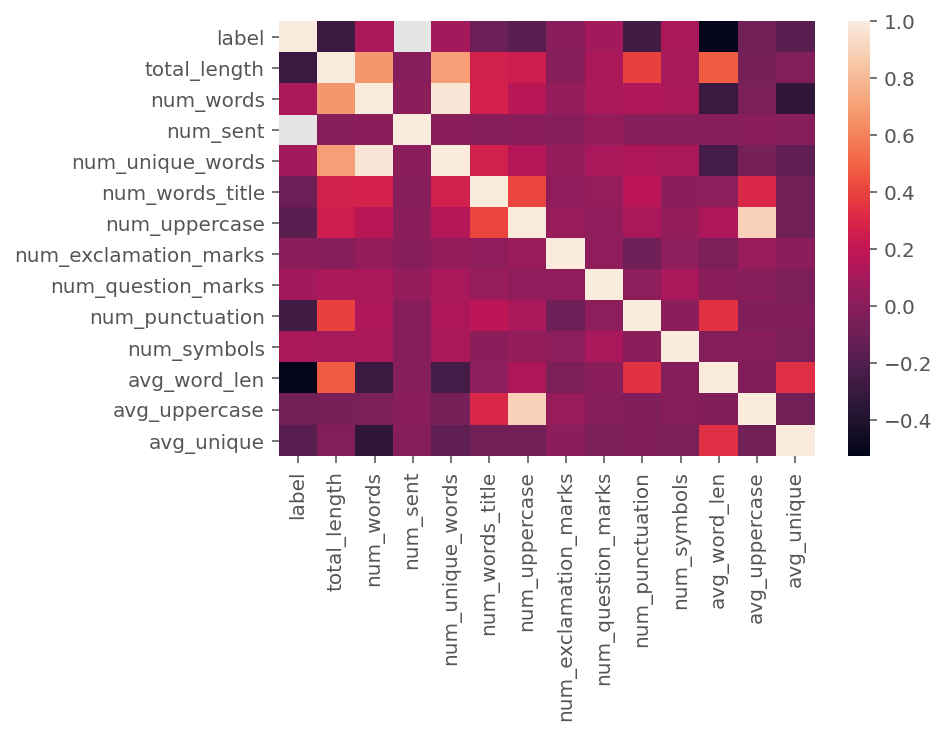

In [56]:
ax = sns.heatmap(df_corr)